<a href="https://colab.research.google.com/github/Neo-Julio/ml4HepNotebook/blob/main/Tempotron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook builds a CNN based on the tempotron DataSet
link: https://zenodo.org/records/7974151

bui

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
!wget https://zenodo.org/records/7974151/files/Dataset.zip?download=1 -O dataset.zip

--2025-08-25 12:12:58--  https://zenodo.org/records/7974151/files/Dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6755452 (6.4M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   6.44M   639KB/s    in 11s     

2025-08-25 12:13:10 (596 KB/s) - ‘dataset.zip’ saved [6755452/6755452]



In [3]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: Dataset/dataset/
   creating: Dataset/dataset/training_dataset/
  inflating: Dataset/dataset/training_dataset/labels.mat  
  inflating: Dataset/dataset/training_dataset/train_labels.txt  
  inflating: Dataset/dataset/training_dataset/training_data_normalized.txt  
   creating: Dataset/dataset/validation_dataset/
 extracting: Dataset/dataset/validation_dataset/labels.mat  
  inflating: Dataset/dataset/validation_dataset/test_labels.txt  
  inflating: Dataset/dataset/validation_dataset/validation_data_normalized.txt  


Now let's visualize the data

In [4]:
!ls Dataset/dataset/validation_dataset/

#!ls -l dataset/training_dataset

labels.mat  test_labels.txt  validation_data_normalized.txt


Some information about the DataSet

In [5]:

# Load training data (waveforms)
x_train = np.loadtxt("Dataset/dataset/training_dataset/training_data_normalized.txt", delimiter=",")

# Load training labels (comma-separated single line)
with open("Dataset/dataset/training_dataset/train_labels.txt", "r") as f:
    line = f.readline()
    y_train = np.array([int(x) for x in line.strip().split(",")])

# Load validation data
x_val = np.loadtxt("Dataset/dataset/validation_dataset/validation_data_normalized.txt", delimiter=",")

# Load validation labels (comma-separated single line)
with open("Dataset/dataset/validation_dataset/test_labels.txt", "r") as f:
    line = f.readline()
    y_val = np.array([int(x) for x in line.strip().split(",")])

# Split validation into validation and test sets (50%-50%)
x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, test_size=0.5, random_state=42, stratify=y_val
)

print("Training set size:", x_train.shape[0])
print("Validation set size:", x_val.shape[0])
print("Test set size:", x_test.shape[0])

print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

Training set size: 1000
Validation set size: 4202
Test set size: 4202
Training labels shape: (1000,)
Validation labels shape: (4202,)
Test labels shape: (4202,)


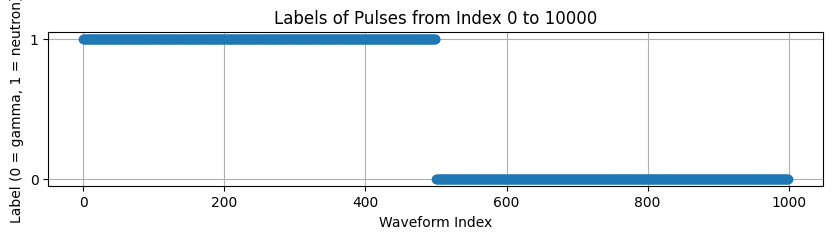

In [6]:
plt.figure(figsize=(10, 2))
plt.plot(y_train[0:1000], 'o')
plt.title("Labels of Pulses from Index 0 to 10000")
plt.xlabel("Waveform Index")
plt.ylabel("Label (0 = gamma, 1 = neutron)")
plt.yticks([0, 1])
plt.grid(True)
#plt.show()

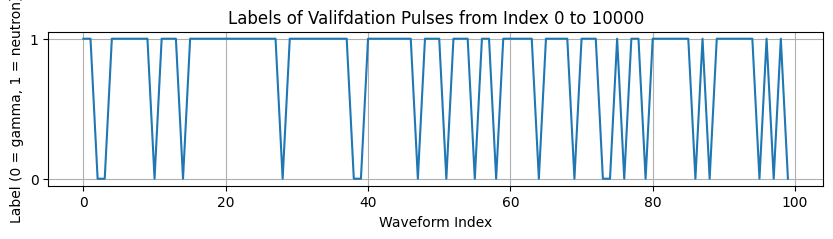

In [ ]:
plt.figure(figsize=(10, 2))
plt.plot(y_val[0:100])
plt.title("Labels of Valifdation Pulses from Index 0 to 10000")
plt.xlabel("Waveform Index")
plt.ylabel("Label (0 = gamma, 1 = neutron)")
plt.yticks([0, 1])
plt.grid(True)
plt.show()

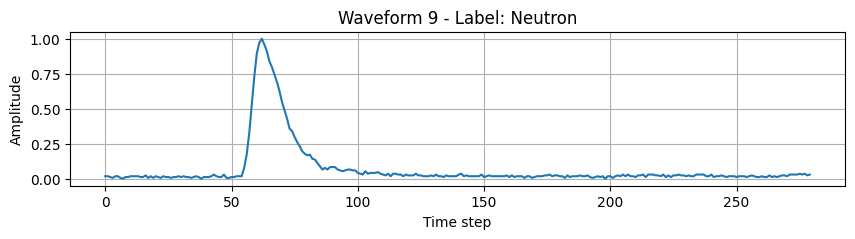

In [8]:
i = 9
plt.figure(figsize=(10, 2))
plt.plot(x_train[i])
label = 'Neutron' if y_train[i] == 1 else 'Gamma'
plt.title(f"Waveform {i} - Label: {label}")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


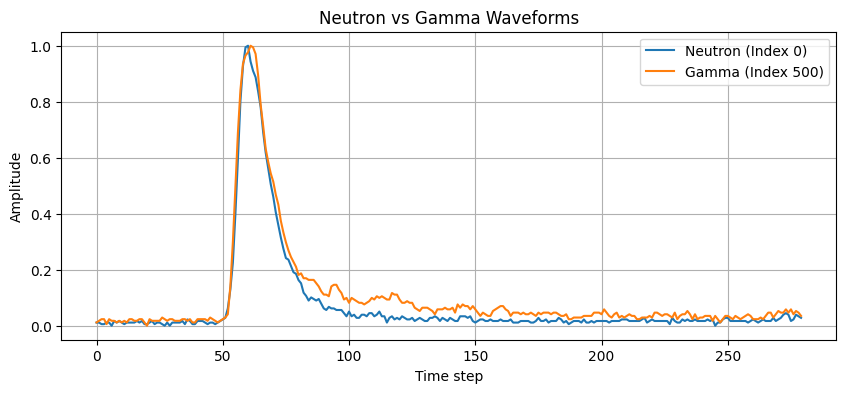

In [9]:
# Find one neutron and one gamma index
neutron_idx = np.where(y_train == 1)[0][0]
gamma_idx = np.where(y_train == 0)[0][0]

plt.figure(figsize=(10, 4))
plt.plot(x_train[neutron_idx], label=f"Neutron (Index {neutron_idx})")
plt.plot(x_train[gamma_idx], label=f"Gamma (Index {gamma_idx})")

plt.title("Neutron vs Gamma Waveforms")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Now let's build a 1D CNN.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PulseCNN(nn.Module):
    def __init__(self):
        super(PulseCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)

        # Compute final flattened size after pooling:
        # Input length: 280
        # After pool1 (stride=2): 140
        # After pool2: 70
        # After pool3: 70 (no pool after conv3)
        self.fc1 = nn.Linear(64 * 70, 128)
        self.fc2 = nn.Linear(128, 2)  # output 2 classes

    def forward(self, x):
        # x shape: (batch_size, 1, 280)
        x = self.pool(F.relu(self.conv1(x)))  # (batch_size, 16, 140)
        x = self.pool(F.relu(self.conv2(x)))  # (batch_size, 32, 70)
        x = F.relu(self.conv3(x))              # (batch_size, 64, 70)
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class PulseDataset(Dataset):
    def __init__(self, X, y):
        # X: numpy array (num_samples, 280)
        # y: numpy array (num_samples,)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Add channel dim for Conv1d: (1, 280)
        sample = self.X[idx].unsqueeze(0)
        label = self.y[idx]
        return sample, label

# Create datasets
train_dataset = PulseDataset(x_train, y_train)
val_dataset = PulseDataset(x_val, y_val)
test_dataset = PulseDataset(x_test, y_test)
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [14]:
model = PulseCNN()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


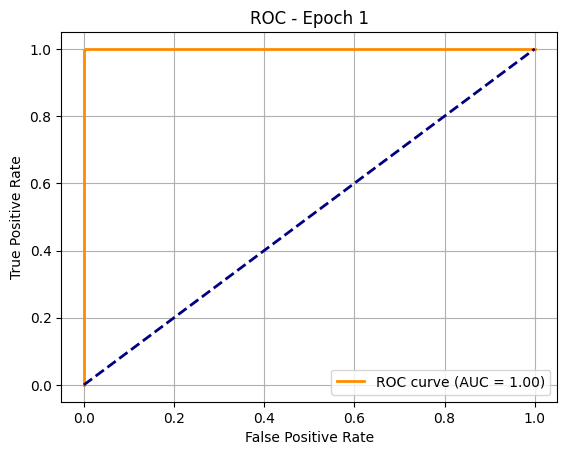

Epoch 2/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


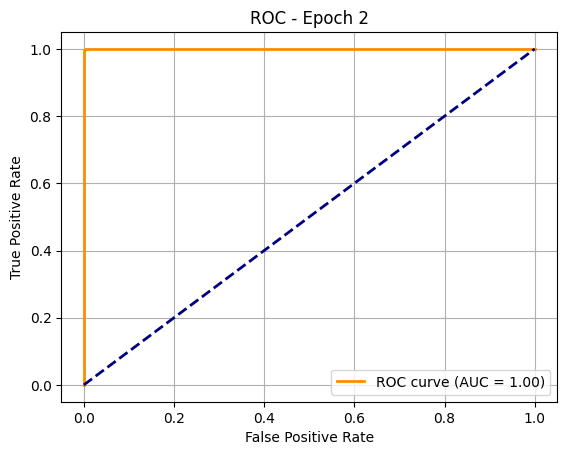

Epoch 3/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


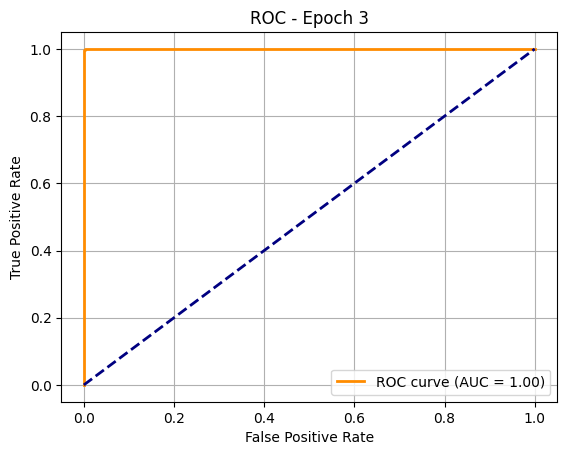

Epoch 4/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


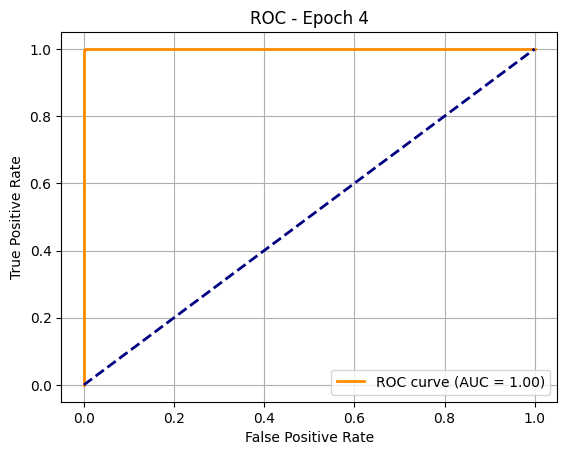

Epoch 5/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


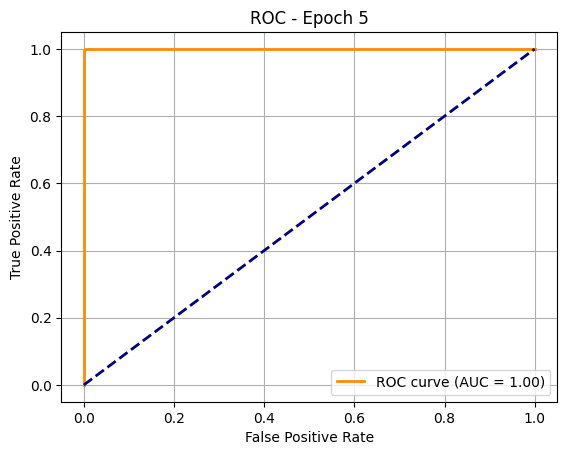

Epoch 6/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


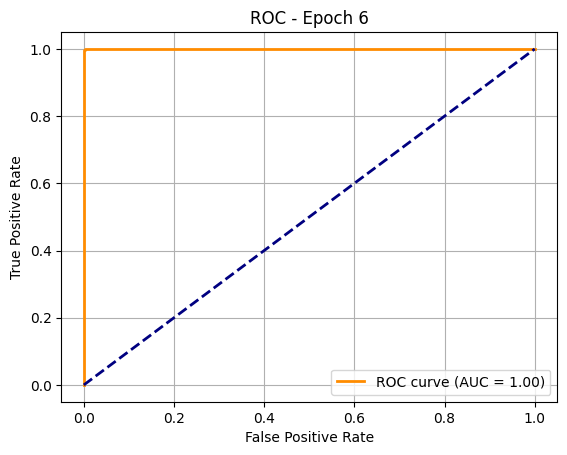

Epoch 7/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


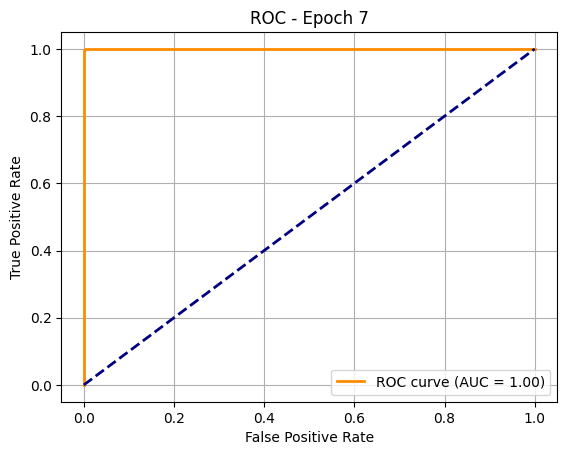

Epoch 8/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


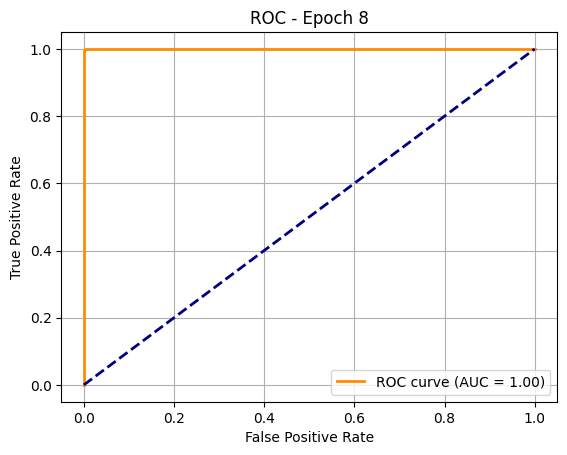

Epoch 9/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


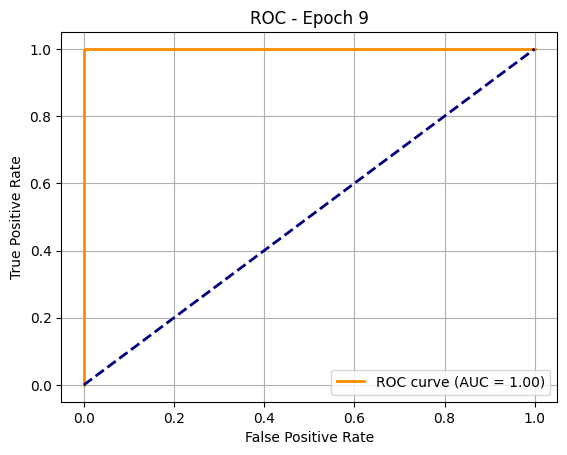

Epoch 10/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


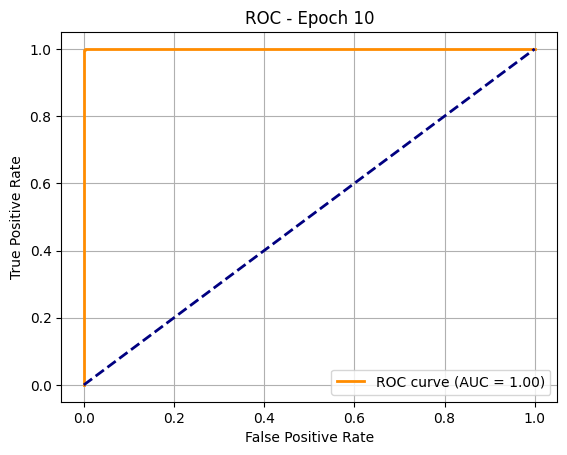

In [21]:
from sklearn.metrics import roc_curve, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)

            # Probabilities for ROC (assuming binary classification)
            probs = torch.softmax(val_outputs, dim=1)[:, 1]

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

            all_labels.extend(val_labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Compute ROC after each epoch
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2,
             label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - Epoch {epoch+1}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1/10 - Loss: 0.6967 - Accuracy: 0.4910
Validation Accuracy: 0.8158
Epoch 2/10 - Loss: 0.6860 - Accuracy: 0.6020
Validation Accuracy: 0.9962
Epoch 3/10 - Loss: 0.5625 - Accuracy: 0.9590
Validation Accuracy: 0.9981
Epoch 4/10 - Loss: 0.1447 - Accuracy: 1.0000
Validation Accuracy: 0.9986
Epoch 5/10 - Loss: 0.0043 - Accuracy: 1.0000
Validation Accuracy: 0.9986
Epoch 6/10 - Loss: 0.0004 - Accuracy: 1.0000
Validation Accuracy: 0.9986
Epoch 7/10 - Loss: 0.0002 - Accuracy: 1.0000
Validation Accuracy: 0.9986
Epoch 8/10 - Loss: 0.0001 - Accuracy: 1.0000
Validation Accuracy: 0.9986
Epoch 9/10 - Loss: 0.0001 - Accuracy: 1.0000
Validation Accuracy: 0.9986
Epoch 10/10 - Loss: 0.0000 - Accuracy: 1.0000
Validation Accuracy: 0.9986


In [18]:
#build the roc
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_np, y_score_np)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


NameError: name 'roc_curve' is not defined